In [2]:
from dask_cloudprovider.aws import EC2Cluster 
from dask.distributed import Client
import configparser
import os
import contextlib
import re
import dask
from platform import python_version

def get_aws_credentials():
    """Read in your AWS credentials file and convert to environment variables."""
    parser = configparser.RawConfigParser()
    
    parser.read(os.path.expanduser('~/.aws/config'))
    config = parser.items('default')
    
    parser.read(os.path.expanduser('~/.aws/credentials'))
    credentials = parser.items('default')
    
    all_credentials = {key.upper(): value for key, value in [*config, *credentials]}
    with contextlib.suppress(KeyError):
        all_credentials["AWS_REGION"] = all_credentials.pop("REGION")
        
    return all_credentials

# Pass in AWS Credentials + any extra packages you would like to install on cluster via `pip`
env_vars = get_aws_credentials()
env_vars["EXTRA_PIP_PACKAGES"] = "s3fs"

# Select software installed on scheduler + worker instances based on client Python + Dask versions
# versions need to match across client, scheduler, worker -- slight mismatches are OK, though
py_v = '-py' + re.findall(r'\d{1}.\d+', python_version())[0]
dask_docker_tag = f"daskdev/dask:{dask.__version__ + py_v}"
print('Docker Image: ', dask_docker_tag)

# launch a cluster of 5 r5.large instances (10 vCPUs):
# 1 scheduler
# 4 workers (2 threads + 16 GB RAM each)
cluster = EC2Cluster(instance_type='r5.large',
                     n_workers=4,
                     security=False,
                     docker_image=dask_docker_tag,
                     env_vars=env_vars
)

Docker Image:  daskdev/dask:2025.2.0-py3.12
Creating scheduler instance
Created instance i-09b95849363cd56f3 as dask-d9653c63-scheduler
Waiting for scheduler to run at 35.175.254.85:8786
Scheduler is running
Creating worker instance
Creating worker instance
Creating worker instance


/opt/anaconda3/envs/clean-env/lib/python3.12/contextlib.py:144: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources. Hang tight! 
  next(self.gen)


Creating worker instance
Created instance i-0009a787e9af798a0 as dask-d9653c63-worker-98c12901
Created instance i-0ac9352a00958d648 as dask-d9653c63-worker-daa8c13f
Created instance i-069a4059a7d5c3398 as dask-d9653c63-worker-8b356ea2
Created instance i-0a09a50d1afa2798c as dask-d9653c63-worker-845f1972


In [12]:
client = Client(cluster)
client.wait_for_workers(4)

In [ ]:
# on scheduler
client.run_on_scheduler(
    lambda: __import__("pip").main(["install",
       "scikit-learn","shapely","geopandas","pyarrow","s3fs"])
)

# on all workers
client.run(lambda: __import__("pip").main(["install",
       "scikit-learn","shapely","geopandas","pyarrow","s3fs"])
)

Applying `log1p` followed by z-score normalization to variables `total_crime`, `school_count`, and `ped_count` helps improve both statistical validity and model performance.

#### 1. **Taming Skew and Handling Zeros (`log1p`)**
- Count variables are typically **right-skewed**, with many small values and a few extreme ones.
- Applying `log1p(x) = log(1 + x)`:
  - Handles **zero values** safely (unlike `log(x)`).
  - Compresses large values and spreads out small ones.
  - Produces a more **normal-like distribution**, which many models prefer.

#### 2. **Standardizing Scale (`z-score`)**
- After log transformation, each feature still has a **different range and variance**.
- Z-scoring (subtract mean, divide by std):
  - Centers each variable at zero.
  - Scales them to unit variance.
  - Ensures that no variable **dominates** due to larger numeric magnitudes.

#### 3. **Improved Model Behavior**
- **Linear models**: Coefficients are interpretable as “effect per 1 standard deviation change.”
- **Neural networks & gradient-based models**: Standardization improves convergence speed and numerical stability.
- **Distance-based models (e.g., KNN, SVM)**: Equal scales prevent bias toward high-magnitude features.

In [7]:
import dask.dataframe as dd
import numpy as np
from dask import compute

df = dd.read_parquet(
    "s3://paul-project-bucket/features/monthly_features_v2_cleaned/",
    storage_options={"anon": False},
    engine="pyarrow"
)

Found credentials in shared credentials file: ~/.aws/credentials

In [ ]:
# Define which count columns we’ll transform
count_cols = ["total_crime", "school_count", "ped_count"]

# Build log‐transformed columns in one go
log_meta = {f"{c}_log": "f8" for c in count_cols}
df = df.assign(
    **{
        f"{c}_log": df[c].map_partitions(np.log1p, meta=(f"{c}_log", "f8"))
        for c in count_cols
    }
)

# Compute global means & stds for all the new log columns in one compute call
log_cols = [f"{c}_log" for c in count_cols]
means, stds = compute(df[log_cols].mean(), df[log_cols].std())

# Z‐score all log columns, again constructing the new columns lazily
df = df.assign(
    **{
        f"{c}_z": (df[f"{c}_log"] - means[f"{c}_log"]) / stds[f"{c}_log"]
        for c in count_cols
    }
)

# Persist (or write out) to trigger execution
df = df.persist()

### Clustering
K-means clustering is employed to uncover latent groupings within the hex-month observations—groupings that may not be apparent through bivariate correlations or univariate analyses—thereby enabling the model to account for non-linear, multivariate interactions among environmental, demographic, and built-form characteristics. By partitioning the data into a predefined number of clusters based on features such as NDVI, land-surface temperature, pedestrian flow, and school density, we generate categorical indicators that capture distinct “neighborhood typologies” or temporal regimes (e.g., high-crime, low-greenness zones versus low-crime, high-vegetation areas). Incorporating these cluster labels as additional predictors in subsequent supervised learning stages allows the model to learn cluster-specific baseline crime intensities and feature effects, improving both predictive accuracy—by reducing within-cluster variance—and interpretability—by facilitating comparisons across coherent subgroups. In sum, k-means clustering operationalizes complex, multidimensional heterogeneity into tractable covariates, strengthening our ability to explain and predict spatial–temporal variations in crime.


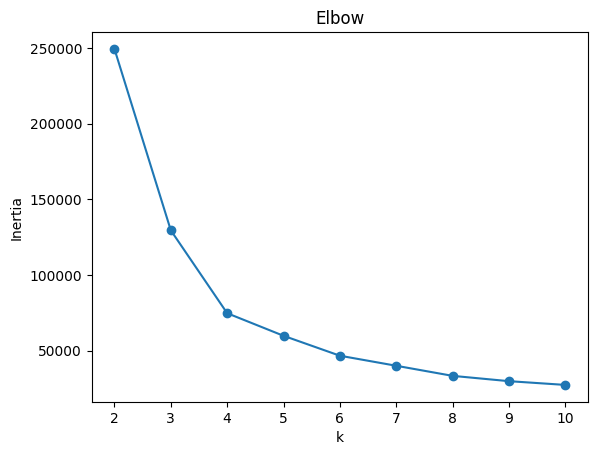

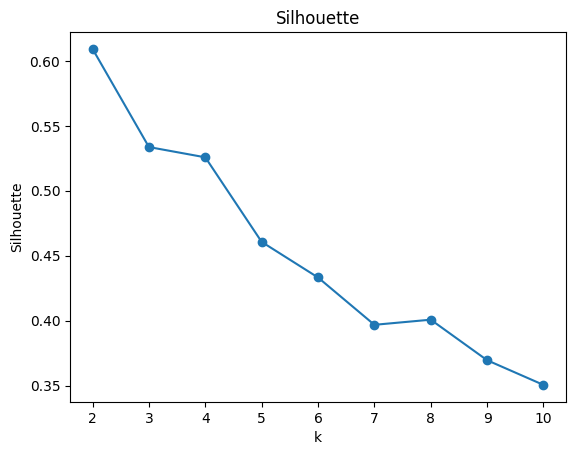

In [ ]:
from dask import delayed, compute
from dask.distributed import Client
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# pull features into memory once
features = ["NDVI", "LST_C", "ped_count_z", "school_count_z"]
X = df[features].compute().values    # shape (8000,4)

# delayed function to fit+score one k
@delayed
def fit_and_score(k, X):
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    return km.inertia_, silhouette_score(X, km.labels_)

# build a list of delayed tasks for k=2…10
ks = list(range(2,11))
tasks = [fit_and_score(k, X) for k in ks]

# compute all in parallel
results = compute(*tasks)
inertias, sil_scores = zip(*results)
plt.figure(); plt.plot(ks, inertias, "o-"); plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow"); plt.show()
plt.figure(); plt.plot(ks, sil_scores, "o-"); plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette"); plt.show()


Selecting k = 3 strikes a balance between compactness and interpretability: the elbow plot shows a pronounced “knee” at three clusters—beyond which inertia reductions flatten—indicating that three centroids capture most of the true structure in the NDVI–LST–pedestrian–school feature space. Although the silhouette score peaks at k = 2, the three‐cluster solution still maintains strong cohesion (≈0.53) while yielding the intuitive regimes “hot & low-veg,” “mixed-regime,” and “cool & high-veg,” offering clear contrast for downstream crime-prediction models without overfitting noise.

In [6]:
import dask.dataframe as dd
from sklearn.cluster import KMeans
import pandas as pd

features = ["NDVI", "LST_C", "ped_count_z", "school_count_z"]

# Compute into Pandas
pdf_X = df[features].compute()  # ~8000×4 in memory

# Fit & predict with sklearn
km = KMeans(n_clusters=3, random_state=42)
labels = km.fit_predict(pdf_X)

# Add cluster labels back to the Dask DataFrame
cluster_series = pd.Series(labels, index=pdf_X.index, name="cluster_3")

df = df.assign(cluster_3=cluster_series)

# Persist or write out
df = df.persist()

The cluster map for August 2015 reveals a clear spatial segmentation of Toronto’s hex‐cells into three distinct regimes:
- Cluster 0 (red) concentrates in the urban core, aligning almost perfectly with high–pedestrian‐traffic, low‐vegetation areas downtown. These hexes tend to have the highest crime_z and lowest NDVI, reflecting “hot & low‐veg” hotspots.
- Cluster 1 (pink) blankets much of the inner suburbs—areas of moderate NDVI and moderate crime—suggesting a “mixed‐regime” where neither heat nor greenness dominates.
- Cluster 2 (teal) appears in scattered pockets (e.g. parklands or waterfront edges) where NDVI is relatively high and crime is lower, capturing the “cool & green” typology.

Overlaying the official neighbourhood boundaries shows that these data‐driven clusters correspond closely to known land‐use and socioeconomic patterns (e.g. downtown vs. parkland vs. residential belts). By transforming these latent spatial regimes into a cluster_3 feature, we can now allow our predictive models to learn cluster‐specific baselines and differential feature effects, improving both accuracy and interpretability of our total_crime forecasts.

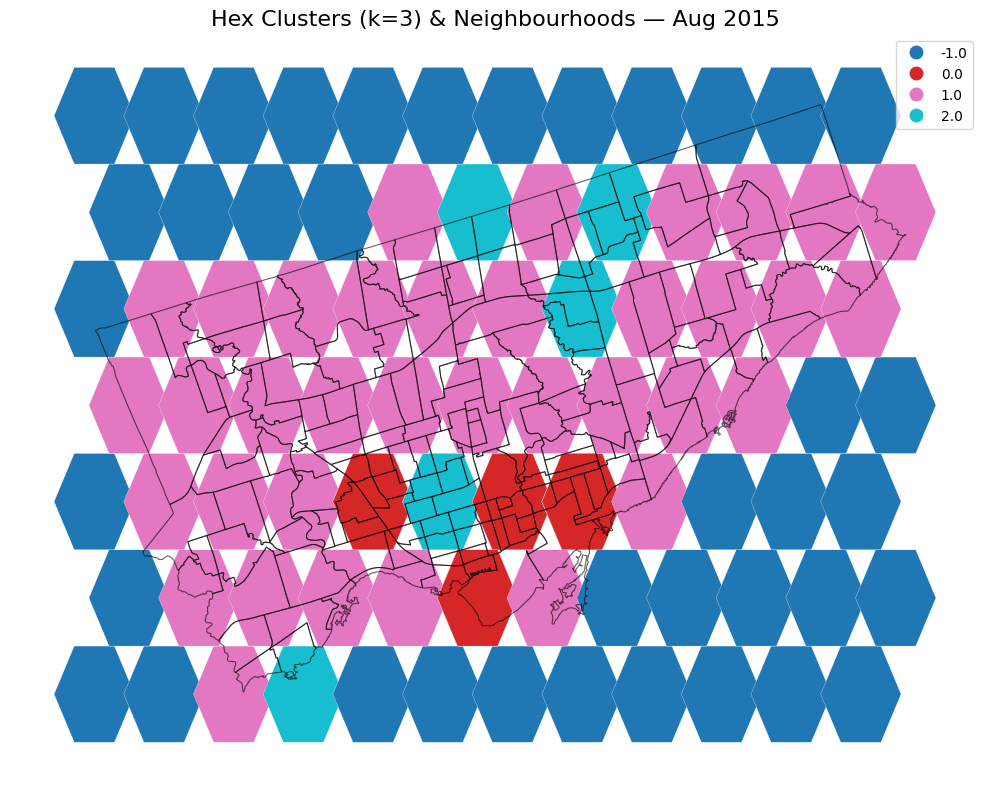

In [40]:
import dask.dataframe as dd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt

# Load hex grid
ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(
    pdf_hex[["hex_id","geometry"]],
    geometry="geometry",
    crs="EPSG:4326"
)

#  Extract year/month_num from 'YYYY-MM' strings
df = df.assign(
    year      = df.month.str.slice(0,4).astype("int64"),
    month_num = df.month.str.slice(5,7).astype("int64"),
)

# Filter for Aug 2015 and bring cluster labels into Pandas
year, month = 2015, 8
pdf_mon = (
    df.loc[(df.year==year)&(df.month_num==month), ["hex_id","cluster_3"]]
      .compute()
)
pdf_mon["hex_id"] = pdf_mon.hex_id.astype(gdf_hex.hex_id.dtype)

# Merge onto hex GeoDataFrame & fill missing as -1
gdf_mon = gdf_hex.merge(pdf_mon, on="hex_id", how="left").fillna({"cluster_3": -1})

# Fetch neighbourhood boundaries & reproject
arcgis_url = (
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
)
nbhd_gdf = gpd.read_file(arcgis_url)

# Reproject both to Web Mercator
gdf_mon_3857  = gdf_mon.to_crs(epsg=3857)
nbhd_gdf_3857 = nbhd_gdf.to_crs(epsg=3857)

# Plot clusters + neighbourhood outlines
fig, ax = plt.subplots(figsize=(10,10))
gdf_mon_3857.plot(
    column="cluster_3",
    categorical=True,
    cmap="tab10",
    legend=True,
    linewidth=0.2,
    edgecolor="white",
    ax=ax
)
nbhd_gdf_3857.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.8,
    alpha=0.6
)


ax.set_title(f"Hex Clusters (k=3) & Neighbourhoods — Aug {year}", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()


The twelve‐panel cluster map for 2022 reveals a pronounced seasonal rhythm in Toronto’s spatial crime regimes while also highlighting a persistent core of elevated risk. During the winter months (January–March, November–December), the data‐driven “cool & green” typology predominates across peripheral hexagons—particularly those aligning with major parklands and waterfront ravines—reflecting lower crime intensities in heavily vegetated, cooler areas. At the same time, the downtown core remains consistently classified as the “high‐crime, low‐veg” regime, albeit covering a smaller footprint in the coldest months, suggesting that urban‐center risk factors such as nightlife and land‐use mix continue to concentrate crime even when weather‐driven pressures are subdued.

As temperatures rise in spring (April–May), the “high‐crime, low‐veg” cluster begins to expand outward from the urban core into adjacent inner‐city neighborhoods. This outward spread peaks in the summer months (June–August), when high land‐surface temperatures and increased pedestrian activity appear to jointly amplify crime risk: the “high‐crime, low‐veg” regime blankets much of central and southern Toronto, while “cool & green” pockets retreat to a few resilient green corridors. These dynamics underscore a strong interaction between environmental heat stress and built‐form vulnerabilities, whereby shaded, vegetated zones continue to exhibit relative crime resilience even amid peak summer conditions.

In early autumn (September–October), a marked contraction of the “high‐crime, low‐veg” cluster and re‐expansion of both the “cool & green” and “low‐veg, low‐ped” regimes signal the city’s transition back to lower‐risk states. By November–December, the pattern mirrors the winter baseline: peripheral green spaces and lower‐pedestrian residential belts dominate, while the core remains a stable hotspot. Taken together, these seasonal shifts validate the hypothesis that elevated surface temperatures and pedestrian density intensify crime in vulnerable areas, while also revealing that entrenched downtown risk factors persist year‐round. Incorporating these dynamic cluster labels into subsequent predictive models promises to capture both enduring spatial heterogeneity and the temporal modulation of crime by environmental conditions.

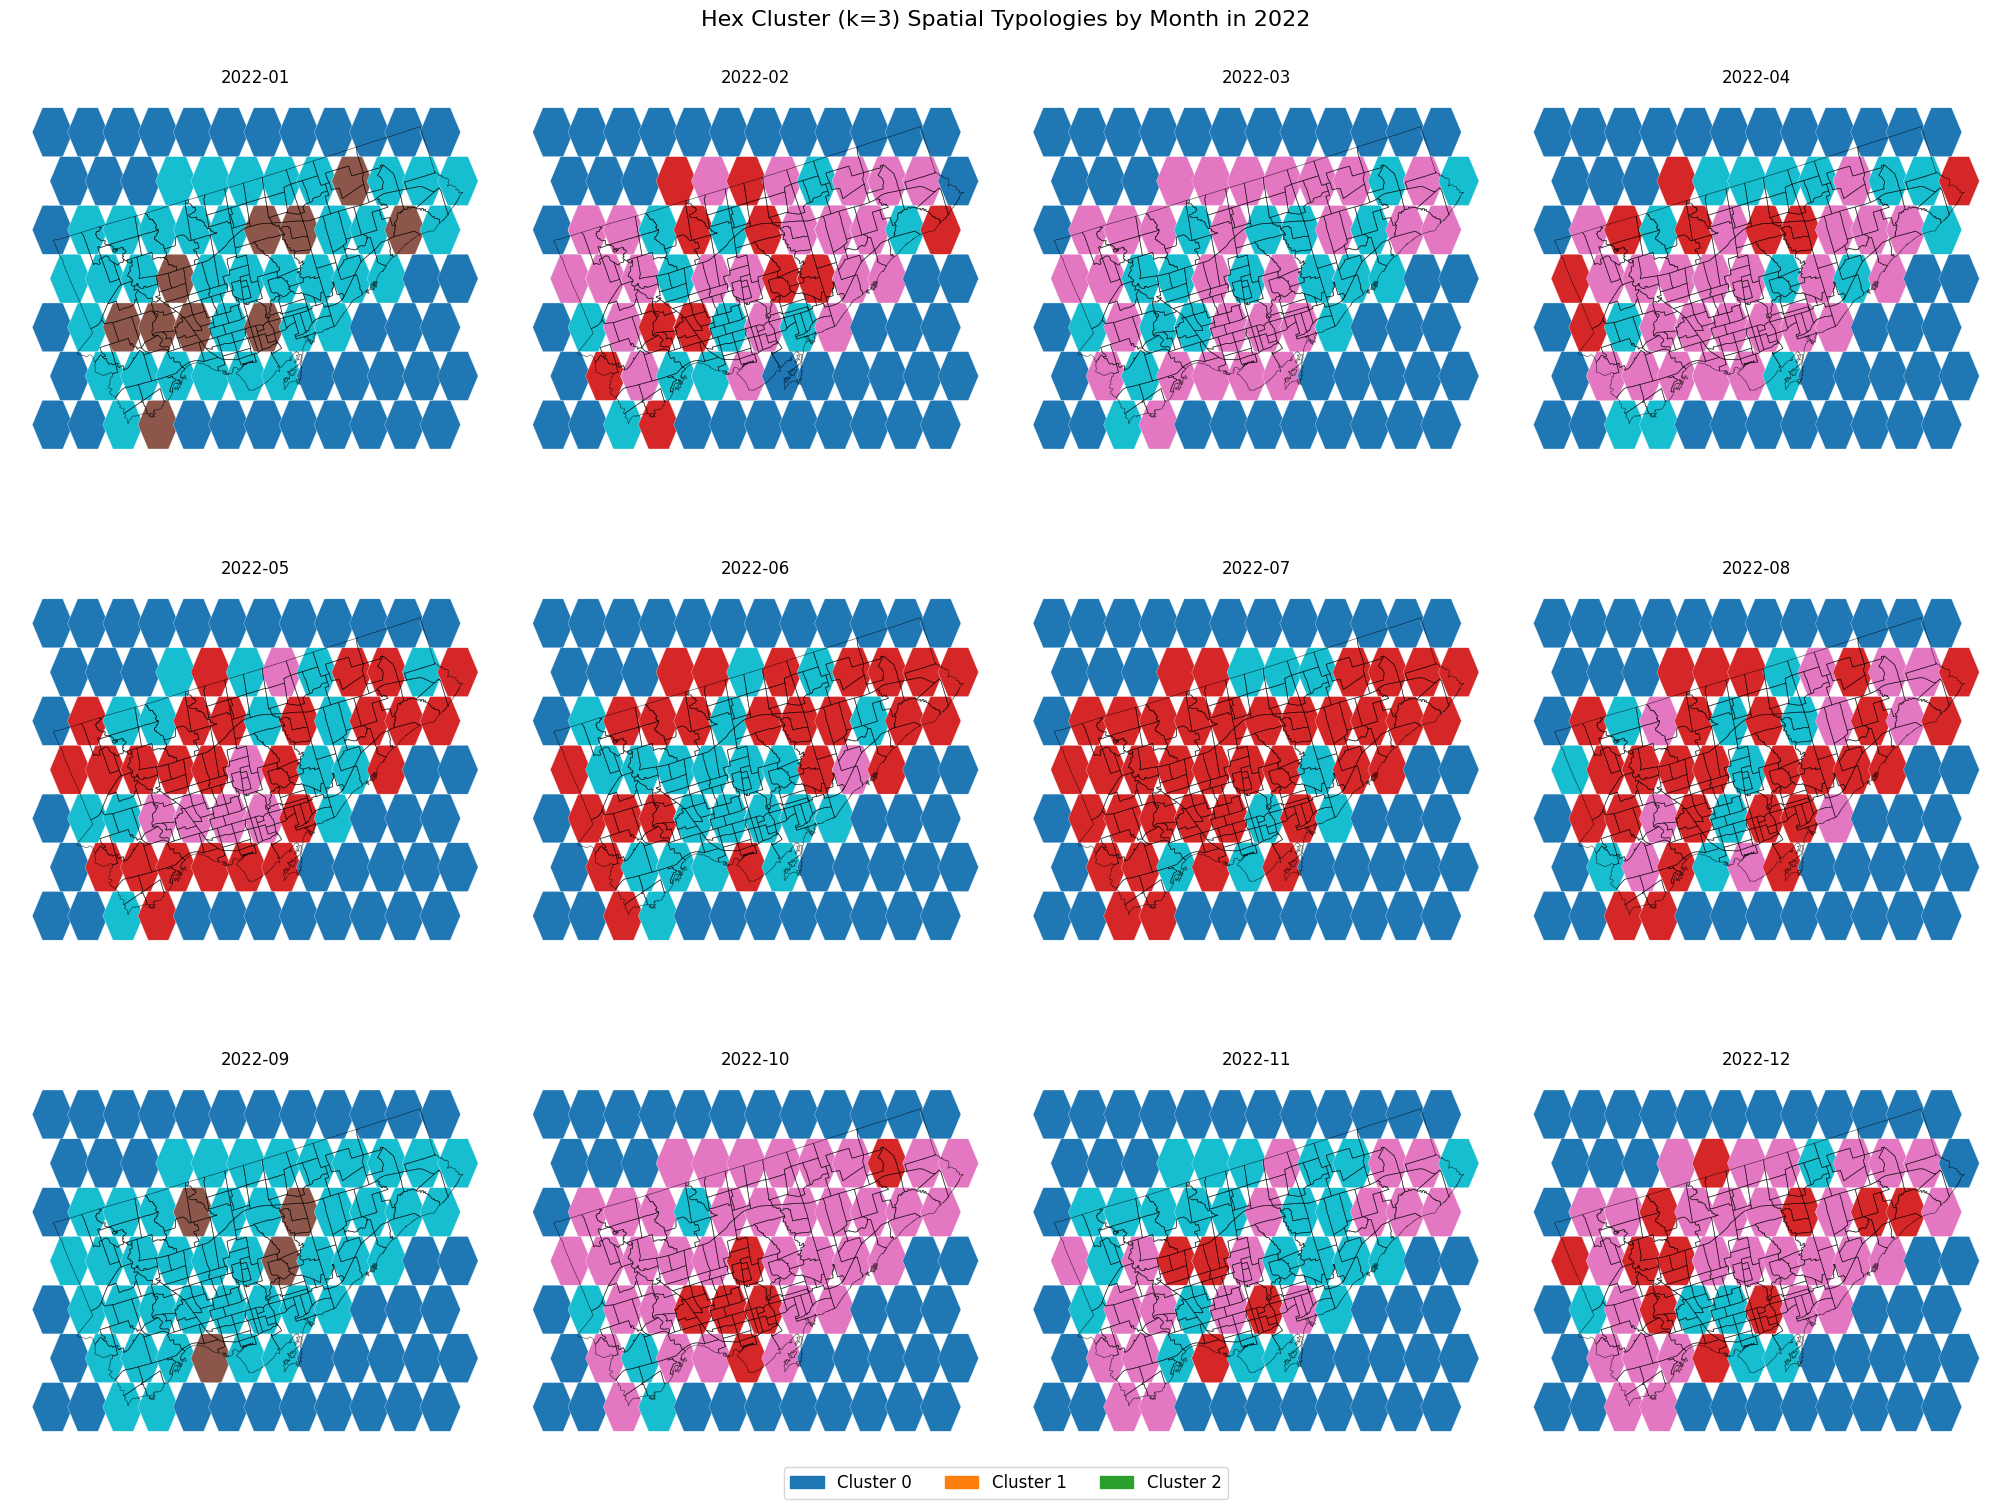

In [42]:
import dask.dataframe as dd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

# Load hex grid & project to Web Mercator
ddf_hex = dd.read_parquet("s3://paul-project-bucket/grid/hex5000.parquet",
                          storage_options={"anon": False}, engine="pyarrow")
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(pdf_hex[["hex_id","geometry"]],
                           geometry="geometry",
                           crs="EPSG:4326")\
           .to_crs(epsg=3857)

# Load features (with cluster_3), derive year & month_num
df = df.assign(
         year      = lambda d: d.month.str.slice(0,4).astype("int64"),
         month_num = lambda d: d.month.str.slice(5,7).astype("int64"),
       )

# Load neighbourhoods & project
arcgis_url = (
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
)
nbhd_gdf = gpd.read_file(arcgis_url).to_crs(epsg=3857)

# Set up 3×4 plot
fig, axes = plt.subplots(3, 4, figsize=(20, 15), constrained_layout=True)
axes = axes.ravel()

year = 2022
for month in range(1, 13):
    ax = axes[month-1]

    # Filter rows & select columns correctly
    cond = (df.year == year) & (df.month_num == month)
    pdf_mon = (
        df.loc[cond, ["hex_id","cluster_3"]]
          .compute()
          .reset_index(drop=True)
    )
    pdf_mon["hex_id"] = pdf_mon.hex_id.astype(gdf_hex.hex_id.dtype)

    # Merge onto the static hex GeoDataFrame
    gdf_mon = (
        gdf_hex[["hex_id","geometry"]]
        .merge(pdf_mon, on="hex_id", how="left")
        .fillna({"cluster_3": -1})
    )

    # Plot the clusters
    gdf_mon.plot(
        column="cluster_3",
        categorical=True,
        cmap="tab10",
        legend=False,
        linewidth=0.2,
        edgecolor="white",
        ax=ax
    )
    nbhd_gdf.boundary.plot(
        ax=ax,
        color="black",
        linewidth=0.5,
        alpha=0.6
    )

    ax.set_title(f"{year}-{month:02d}", fontsize=12)
    ax.axis("off")

# Shared legend
import matplotlib.patches as mpatches
cluster_ids = sorted(df.cluster_3.drop_duplicates().compute())
colors = plt.get_cmap("tab10")(range(len(cluster_ids)))
handles = [mpatches.Patch(color=colors[i], label=f"Cluster {cluster_ids[i]}") 
           for i in range(len(cluster_ids))]
fig.legend(handles=handles, loc="lower center", ncol=len(handles), fontsize=12)

fig.suptitle(f"Hex Cluster (k=3) Spatial Typologies by Month in {year}", fontsize=16)
plt.show()

The suite of distance‐to‐centroid heatmaps offers a nuanced, continuous portrait of how each hexagon’s environmental and built‐form characteristics align with the three latent regimes identified by k-means clustering. In the first panel, minimal distances to Centroid 0 delineate a broad peripheral band of “low-crime, low-veg” hexagons. These uniformly dark regions correspond to residential belts where pedestrian activity is modest, land‐surface temperatures remain moderate, and crime rates are relatively subdued. The sharp contrast between these outer zones and the lighter, more distant central hexagons underscores a clear spatial buffer separating tranquil suburbs from the urban core.

The second panel, mapping distances to Centroid 1, reveals a tightly concentrated downtown hotspot. Here, the darkest hexagons—those nearest to the “high-crime, low-veg” prototype—trace the city’s commercial and entertainment districts, where heat stress and high pedestrian flows coincide with elevated crime. The rapid gradient of distance values moving outward highlights the steep transition from intense urban risk environments to more muted, mixed-use neighborhoods. This sharp boundary suggests that small shifts in environmental or social conditions could precipitate disproportionate changes in crime risk near the city center.

In the third panel, the “cool & green” regime emerges in dark tones along Toronto’s major parklands and ravine systems, including the Don Valley and High Park corridors. These areas exhibit the highest NDVI and the lowest land‐surface temperatures, creating durable refuges of relative crime resilience. Surrounding hexagons display progressively lighter hues, signifying their gradual departure from this vegetated archetype. Together, the three heatmaps trace a continuous gradient from verdant, low‐risk peripheries through moderate residential zones to the crime‐intensive core.

By incorporating these continuous distance measures—rather than relying solely on discrete cluster labels—into subsequent predictive models, we can more precisely quantify each hexagon’s proximity to latent risk or protective regimes. This approach enriches model flexibility, allowing for subtle, location-specific interpretations of how incremental changes in greenness, heat, or pedestrian density may modulate crime outcomes.

The bootstrap‐based stability map quantifies the robustness of each hexagon’s cluster assignment by measuring the fraction of resampled K-means fits in which its label agrees with the original solution. Hexagons in deep blue (stability ≈ 1.0) lie at the heart of their respective regimes—either firmly in the low-crime residential belt around the edges or squarely within the downtown high-crime core—indicating that their feature signatures (NDVI, LST, pedestrian density, school count) are so prototypical that even resampling noise cannot dislodge them.

By contrast, the lighter-shaded hexagons (stability ≈ 0.3–0.6) cluster along the transitional margins between regimes, most notably at the interface of the urban core and inner suburbs. These “fuzzy boundary” cells capture neighborhoods whose environmental and social characteristics are intermediate—neither fully high-crime nor fully green—rendering their cluster membership sensitive to slight perturbations in the data. Such areas may represent evolving land-use zones or mixed-use corridors where crime and greenness interact more heterogeneously.

Importantly, the stability heatmap validates the three-cluster solution’s overall coherence while flagging the specific spatial domains where regime definitions are most ambiguous. In subsequent modeling, one might weight distance or stability measures to downplay lower-confidence assignments or explicitly model boundary uncertainty. This nuanced stability metric thus not only reinforces the credibility of core cluster assignments but also guides targeted investigation—and potential policy intervention—in the city’s most dynamic transitional zones.

Bootstraps: 100%|██████████| 100/100 [00:02<00:00, 44.41it/s]


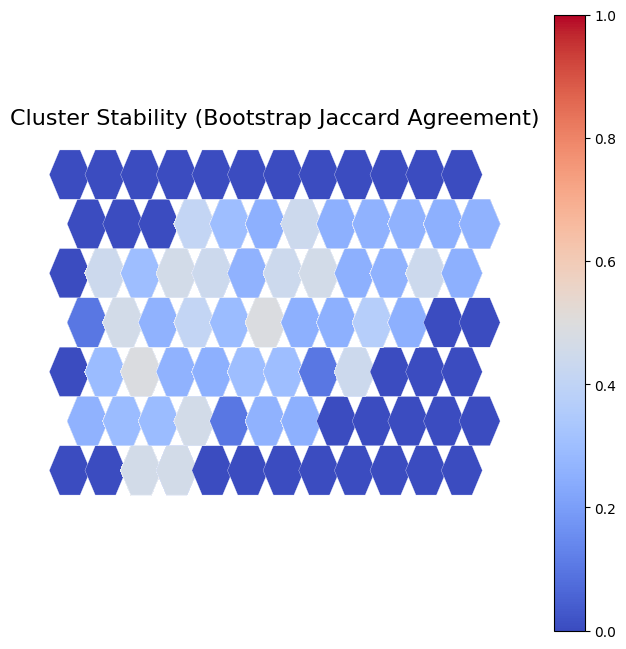

In [44]:
n_boot = 100
n = X.shape[0]

stability_counts = np.zeros(n, dtype=int)

for _ in tqdm(range(n_boot), desc="Bootstraps"):
    sample_idx = np.random.choice(n, size=n, replace=True)
    X_boot    = X[sample_idx]
    
    km_boot = KMeans(n_clusters=3, random_state=None).fit(X_boot)
    
    # Predict labels for the *original* points
    labels_boot = km_boot.predict(X)
    stability_counts += (labels_boot == orig_labels).astype(int)

# Compute stability score = fraction of times label agreed
stability_score = stability_counts / n_boot
pdf["stability"] = stability_score

# Merge and plot stability as a continuous heatmap
gdf2 = gdf_hex.merge(pdf[["stability"]].reset_index(), on="hex_id", how="left").fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
gdf2.plot(column="stability",
          cmap="coolwarm",
          legend=True,
          ax=ax,
          edgecolor="white",
          linewidth=0.2,
          vmin=0, vmax=1,
          missing_kwds={"color": "lightgrey"})
ax.set_title("Cluster Stability (Bootstrap Jaccard Agreement)", fontsize=16)
ax.axis("off")
plt.show()

In [10]:
client.close()
cluster.close()

Terminated dask-d9653c63-worker-98c12901 (i-0009a787e9af798a0)
Terminated dask-d9653c63-worker-daa8c13f (i-0ac9352a00958d648)
Terminated dask-d9653c63-worker-845f1972 (i-0a09a50d1afa2798c)
Terminated dask-d9653c63-worker-8b356ea2 (i-069a4059a7d5c3398)
Terminated dask-d9653c63-scheduler (i-09b95849363cd56f3)
